In [1]:
import warnings
warnings.filterwarnings(action='ignore')
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'NanumGothicCoding'
plt.rcParams['font.size'] = 10
import seaborn as sns

In [2]:
# 학습 데이터와 테스트 데이터의 비율을 지정해서 무작위로 분리하기 위해 import 한다.
from sklearn.model_selection import train_test_split
# 교차 검증을 실행하기 위해서 import 한다.
from sklearn.model_selection import cross_val_score
# kNN 분류기를 사용하기 위해서 import 한다.
from sklearn.neighbors import KNeighborsClassifier
# 모델의 정확도를 계산하기 위해서 import 한다.
from sklearn.metrics import accuracy_score

데이터 획득

In [3]:
# Player(선수이름), Pos(포지션), 3P(3점슛), 2P(2점슛), TRB(리바운드), AST(어시스트), STL(스틸), BLK(블록슛)
df = pd.read_csv('./data/basketball_stat.csv')
df

,Player,Pos,3P,2P,TRB,AST,STL,BLK
0,Alex Abrines,SG,1.4,0.6,1.3,0.6,0.5,0.1
1,Steven Adams,C,0.0,4.7,7.7,1.1,1.1,1.0
2,Alexis Ajinca,C,0.0,2.3,4.5,0.3,0.5,0.6
3,Chris Andersen,C,0.0,0.8,2.6,0.4,0.4,0.6
4,Will Barton,SG,1.5,3.5,4.3,3.4,0.8,0.5
...,...,...,...,...,...,...,...,...
95,Nikola Vucevic,C,0.3,6.1,10.4,2.8,1.0,1.0
96,Dwyane Wade,SG,0.8,6.2,4.5,3.8,1.4,0.7
97,Dion Waiters,SG,1.8,4.3,3.3,4.3,0.9,0.4
98,Hassan Whiteside,C,0.0,7.0,14.1,0.7,0.7,2.1


In [4]:
df.Pos.value_counts()

SG    50
C     50
Name: Pos, dtype: int64

데이터 시각화

<Figure size 800x600 with 0 Axes>

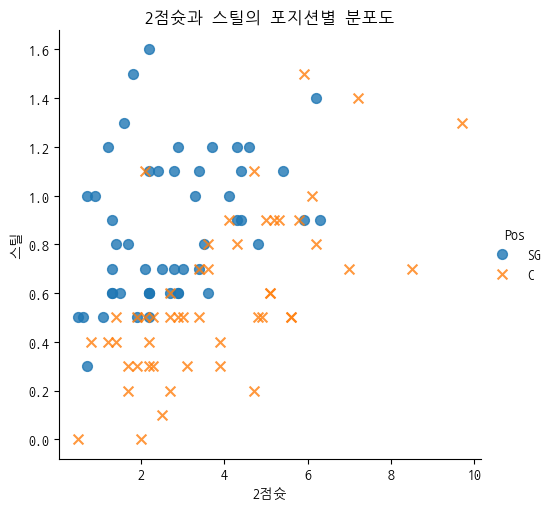

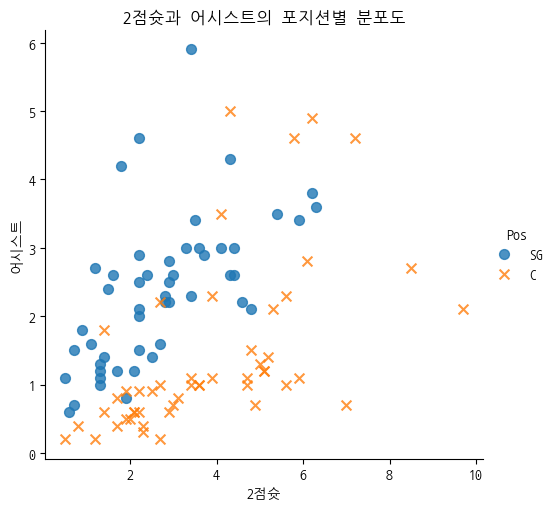

In [5]:
# 2P와 STL, 2P와 AST의 Pos별 분포도를 출력한다.
plt.figure(figsize=(8, 6))
sns.lmplot(
    data=df, x='2P', y='STL', fit_reg=False, # 데이터, x축, y축, 회귀선 표시 여부
    hue='Pos', # 그래프에 표시되는 표식의 색상 => 범례가 자동으로 표시된다.
    scatter_kws={'s': 50}, # 그래프에 표시되는 표식의 크기
    markers=['o', 'x'] # 그래프에 표시되는 표식의 종류
)
plt.title('2점슛과 스틸의 포지션별 분포도')
plt.xlabel('2점슛')
plt.ylabel('스틸')
# ==============================================================================
sns.lmplot(data=df, x='2P', y='AST', fit_reg=False, hue='Pos', scatter_kws={'s': 50}, markers=['o', 'x'])
plt.title('2점슛과 어시스트의 포지션별 분포도')
plt.xlabel('2점슛')
plt.ylabel('어시스트')
plt.show()

<Figure size 800x600 with 0 Axes>

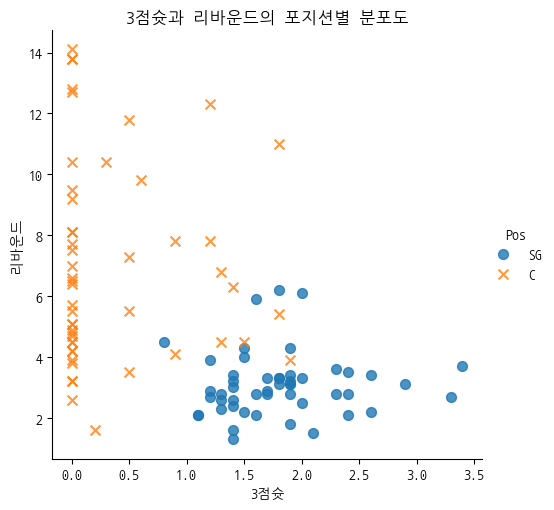

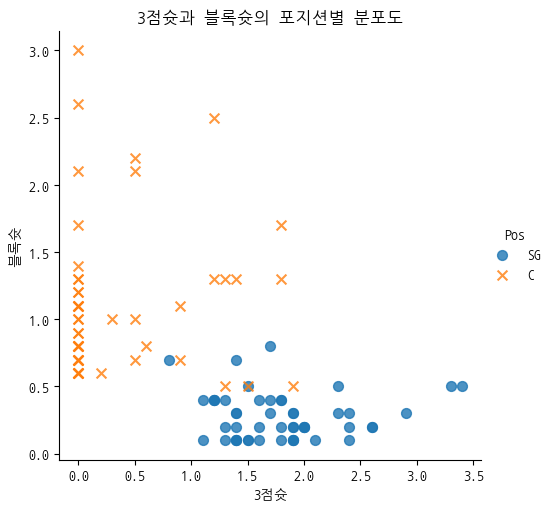

In [6]:
# 3P와 TRB, 3P와 BLK의 Pos별 분포도를 출력한다.
plt.figure(figsize=(8, 6))
sns.lmplot(data=df, x='3P', y='TRB', fit_reg=False, hue='Pos', scatter_kws={'s': 50}, markers=['o', 'x'])
plt.title('3점슛과 리바운드의 포지션별 분포도')
plt.xlabel('3점슛')
plt.ylabel('리바운드')
# ==============================================================================
sns.lmplot(data=df, x='3P', y='BLK', fit_reg=False, hue='Pos', scatter_kws={'s': 50}, markers=['o', 'x'])
plt.title('3점슛과 블록슛의 포지션별 분포도')
plt.xlabel('3점슛')
plt.ylabel('블록슛')
plt.show()

데이터 전처리

In [7]:
# 판다스의 drop() 메소드로 불필요한 컬럼(피쳐)를 삭제한다.
# drop() 메소드의 axis 속성은 생략시 기본값이 0으로 행 단위로 삭제하고 1로 지정하면 열 단위로 삭제한다.
# df = df.drop(['2P', 'AST', 'STL'], axis=1)
# inplace 속성은 생략시 False가 기본값으로 실행 결과를 데이터프레임에 즉시 반영하지 않고 True를 써주면
# 실행 결과를 데이터프레임에 즉시 반영한다.
df.drop(['2P', 'AST', 'STL'], axis=1, inplace=True)
df

,Player,Pos,3P,TRB,BLK
0,Alex Abrines,SG,1.4,1.3,0.1
1,Steven Adams,C,0.0,7.7,1.0
2,Alexis Ajinca,C,0.0,4.5,0.6
3,Chris Andersen,C,0.0,2.6,0.6
4,Will Barton,SG,1.5,4.3,0.5
...,...,...,...,...,...
95,Nikola Vucevic,C,0.3,10.4,1.0
96,Dwyane Wade,SG,0.8,4.5,0.7
97,Dion Waiters,SG,1.8,3.3,0.4
98,Hassan Whiteside,C,0.0,14.1,2.1


학습(train) 데이터와 테스트(test) 데이터로 나누기

In [8]:
# train_test_split() 메소드는 학습 데이터와 테스트 데이터를 지정한 비율로 나누는 기능을 실행한다.
# train_test_split(데이터[, train_size, test_size, random_state, shuffle])
# train_size 옵션으로 학습 데이터의 비율을 지정하고 test_size 옵션으로 테스트 데이터의 비율을 지정한다.
# 학습 데이터와 테스트 데이터의 비율을 지정하지 않으면 학습 데이터 75%, 테스트 데이터 25 비율로 나눈다.
# random_state 옵션을 지정하면 매번 같은 데이터를 학습 데이터와 테스트 데이터로 나눈다.
# shuffle 옵션을 False로 지정하면 학습 데이터와 테스트 데이터로 나눌 때 섞지않고 나눈다.
train, test = train_test_split(df, train_size=0.8, test_size=0.2)
print(train.shape[0], test.shape[0])

80 20


최적의 kNN 파라미터 찾기

sklesrn 라이브러리의 cross_val_score() 메소드로 k-fold 교차 검증을 사용해서 kNN 알고리즘의 조절 가능한 단 하나의 변수값 k를 찾는다.  
k-fold 교차 검증은 train 데이터를 k개로 나눠서 k번 정확도를 검증하는 방법이다.

<img src="./k-fold.png" align="left" width="600"/>

In [9]:
# 최적의 k를 찾기위해 교차 검증을 수행할 k의 범위를 3부터 학습 데이터 개수의 절반까지 홀수로 저장한다.
k_list = []
for i in range(3, train.shape[0] // 2, 2):
    k_list.append(i)
print(k_list)

[3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]


In [10]:
# 각각의 k별 10-fold 교차 검증 결과의 평균을 기억할 빈 리스트를 선언한다.
cross_validation_scores = []
# train_test_split() 메소드로 분리한 train 데이터에서 학습에 사용할 데이터(피쳐)를 저장한다.
x_train = train[['3P', 'TRB', 'BLK']]
# train_test_split() 메소드로 분리한 train 데이터에서 학습 결과로 사용할 데이터(실제값, 레이블, 클래스, 타겟)를 저장한다.
y_train = train['Pos']

10-fold 교차 검증

train 데이터를 10개의 조각으로 나누고 1조각을 검증(validation) 데이터로 사용하고 나머지 9조각을 학습 데이터로 사용해서 1번째 조각부터 10번째 조각까지 1번씩 검증하고 10번의 검증 결과를 10으로 나눈 평균을 검증 결과 점수로 한다.

cross_val_score(model, x, y, scoring, cv)  
model: 분석 모델  
x: 독립 변수, 학습 데이터(피쳐)  
y: 종속 변수, 학습 데이터의 학습 결과(실제값, 레이블, 클래스, 타겟)  
scoring: 성능 검증에 사용할 평가 지표, 정확도를 의미하는 'accuracy'를 지정한다.  
cv: 교차 검증 조각의 개수

In [11]:
# 10-fold 교차 검증을 k_list에 저장된 각각의 값을 대상으로 실행해서 검증 결과를 저장한다.
for k in k_list:
    # KNeighborsClassifier 클래스의 생성자로 n_neighbors에 kNN 모델에서 사용할 이웃의 개수를 지정해 kNN 모델을 만든다.
    knn = KNeighborsClassifier(n_neighbors=k)
    # 학습에 따른 결과(실제값, 레이블, 타겟)는 1차원 형태로 지정해야 하므로 values.ravel() 메소드를 사용해서
    # 1차원으로 변경한다.
    scores = cross_val_score(knn, x_train, y_train.values.ravel(), scoring='accuracy', cv=10)
    cross_validation_scores.append(scores.mean())
    print('k: {:2d}, scores: {}, mean: {}'.format(k, scores, scores.mean()))

k:  3, scores: [1.    0.875 1.    0.75  1.    0.75  0.875 0.875 0.875 1.   ], mean: 0.9
k:  5, scores: [1.    1.    1.    0.75  1.    0.75  0.75  0.875 0.875 1.   ], mean: 0.9
k:  7, scores: [1.    1.    1.    0.75  1.    0.75  0.75  0.875 1.    1.   ], mean: 0.9125
k:  9, scores: [1.    1.    1.    0.75  1.    0.875 0.75  0.875 1.    1.   ], mean: 0.925
k: 11, scores: [1.    1.    1.    0.875 1.    0.75  0.75  0.875 1.    1.   ], mean: 0.925
k: 13, scores: [1.    1.    1.    0.875 1.    0.75  0.75  0.875 1.    1.   ], mean: 0.925
k: 15, scores: [1.    1.    1.    0.875 1.    0.75  0.75  0.75  1.    1.   ], mean: 0.9125
k: 17, scores: [1.   1.   1.   0.75 1.   0.75 0.75 0.75 1.   1.  ], mean: 0.9
k: 19, scores: [1.   1.   1.   0.75 1.   0.75 0.75 0.75 1.   1.  ], mean: 0.9
k: 21, scores: [1.   1.   1.   0.75 1.   0.75 0.75 0.75 1.   1.  ], mean: 0.9
k: 23, scores: [1.   1.   1.   0.75 1.   0.75 0.75 0.75 1.   1.  ], mean: 0.9
k: 25, scores: [1.   1.   1.   0.75 1.   0.75 0.75 0.75 1.  

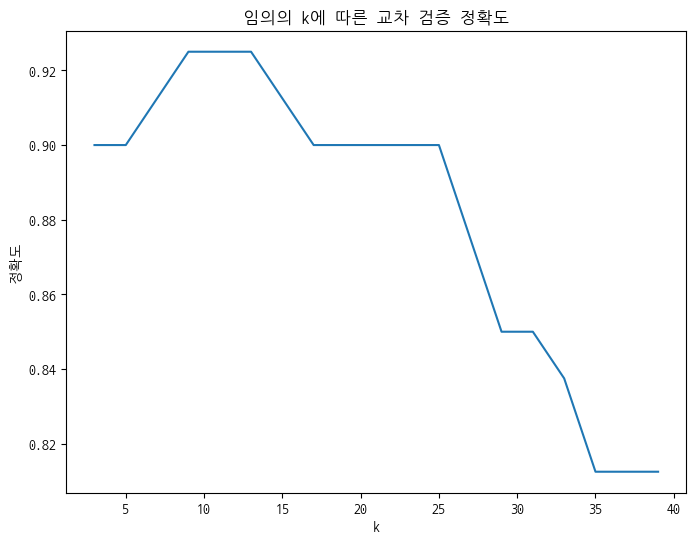

In [12]:
plt.figure(figsize=(8, 6))
plt.plot(k_list, cross_validation_scores)
plt.title('임의의 k에 따른 교차 검증 정확도')
plt.xlabel('k')
plt.ylabel('정확도')
plt.show()

In [13]:
# 예측율이 가장 높은 k를 선정한다.
print(cross_validation_scores)
print(max(cross_validation_scores))
# index() 메소드는 인수로 지정된 값이 최초로 출현하는 인덱스를 출력한다.
optimal_k = k_list[cross_validation_scores.index(max(cross_validation_scores))]
print('최적의 k: {}'.format(optimal_k))

[0.9, 0.9, 0.9125, 0.925, 0.925, 0.925, 0.9125, 0.9, 0.9, 0.9, 0.9, 0.9, 0.875, 0.85, 0.85, 0.8375, 0.8125, 0.8125, 0.8125]
0.925
최적의 k: 9


최적의 k를 사용한 kNN 모델 테스트

In [14]:
# 분별력이 있다고 판단된 3P, TRB, BLK 피쳐로 모델을 학습시킨 후 테스트를 진행한다.
knn = KNeighborsClassifier(n_neighbors=optimal_k)
# 모델 학습에 사용할 피쳐와 타겟을 지정한다.
x_train = train[['3P', 'TRB', 'BLK']]
y_train = train['Pos']
# 피쳐(x_train)와 타겟(y_train)을 이용해서 모델을 학습시킨다.
knn.fit(x_train, y_train.values.ravel())

# 모델 최종 테스트에 사용할 피쳐와 타겟을 지정한다.
x_test = test[['3P', 'TRB', 'BLK']]
y_test = test['Pos']

# 테스트 데이터를 사용해 예측해보고 모델의 정확도를 계산한다.
# predict() 메소드의 인수로 테스트 데이터의 피쳐를 넘겨서 테스트 데이터의 예측값을 얻어온다.
predict = knn.predict(x_test) # 테스트 데이터 예측
# accuracy_score() 메소드의 인수로 테스트 데이터의 타겟과 테스트 데이터의 예측값을 넘겨서 정확도를 얻어온다.
accuracy = accuracy_score(y_test.values.ravel(), predict)
print('정확도: {:6.2%}'.format(accuracy))

정확도: 80.00%


In [15]:
pd.DataFrame({'실제값': y_test.values.ravel(), '예측값': predict})

,실제값,예측값
0,SG,SG
1,SG,SG
2,SG,SG
3,C,SG
4,SG,SG
5,C,C
6,C,C
7,C,C
8,C,C
9,C,C


완성된 모델 사용하기

In [16]:
x = {'3P': [0, 3.9], 'TRB': [1, 0.1], 'BLK': [7.7, 0.3]}
x_test = pd.DataFrame(x)
x_test

,3P,TRB,BLK
0,0.0,1.0,7.7
1,3.9,0.1,0.3


In [17]:
y = {'Pos': ['C', 'SG']}
y_test = pd.DataFrame(y)
y_test

,Pos
0,C
1,SG


In [18]:
predict = knn.predict(x_test)
print(predict)
accuracy = accuracy_score(y_test.values.ravel(), predict)
print('정확도: {:6.2%}'.format(accuracy))

['C' 'SG']
정확도: 100.00%


In [19]:
pd.DataFrame({'실제값': y_test.values.ravel(), '예측값': predict})

,실제값,예측값
0,C,C
1,SG,SG
